# Wrapper methods

Wrapper methods recursively decide what the best feature is to add or remove to the set of features to find the optimal feature set.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from matplotlib import pyplot as plt
from math import sqrt
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score

Load the houses dataset. Because we want to focus on features, we simply remove records with missing values. Note that you should normall do this with more care! We also convert categories to dummy variables and create a train and test set.

In [2]:
df = pd.read_csv('/data/datasets/bank-additional-full.csv', delimiter=';')

In [3]:
df = df.drop(columns=df.columns[df.isnull().any()])

In [4]:
df.y = (df.y == 'yes').astype(int)

In [5]:
df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns, drop_first=True)

In [6]:
all_features = df.columns.drop('y')

In [7]:
train_X, valid_X, train_y, valid_y = train_test_split(df[all_features], df.y, test_size=0.2)

In [8]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2)

There are 26k rows in the training set and 53 features.

In [9]:
train_X.shape

(26360, 53)

In [10]:
#poly = PolynomialFeatures(degree=1)
#train_X = poly.fit_transform(train_X)
#valid_X = poly.fit_transform(valid_X)
#test_X = poly.fit_transform(test_X)

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)

Let's train a model on all of the training data.

In [11]:
model = LogisticRegression(penalty='none')
model.fit(train_X, train_y)
pred_y = model.predict(valid_X)
f1_score(valid_y, pred_y)

0.503957783641161

SKLearn has a Recursive Feature Elimination function that will Recursively find the best features by adding one at a time.

In [12]:
model = LogisticRegression(penalty='none')
rfe = RFE(model, n_features_to_select=20)
rfe.fit(train_X, train_y)

RFE(estimator=LogisticRegression(penalty='none'), n_features_to_select=20)

In [13]:
all_features[rfe.get_support()]

Index(['duration', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'job_blue-collar', 'default_unknown',
       'default_yes', 'contact_telephone', 'month_aug', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [14]:
model.fit(rfe.transform(train_X), train_y)
f1_score(valid_y, model.predict(rfe.transform(valid_X)))

0.4966711051930759

We then learn and validate $k$ models that hold the best $k$ features. We use the F1-score here, whch is de harmonic mean between recall and precision, since it is easier to compare the models with just one number.

In [15]:
f1v = []
f1t = []
for k in range(1, train_X.shape[1]):
    # use only the k best features
    
    model = LogisticRegression(penalty='none')
    rfe = RFE(model, n_features_to_select=k)
    rfe.fit(train_X, train_y)
    
    # fit the model and run the evaluation
    model.fit(rfe.transform(train_X), train_y)
    f1v.append(f1_score(valid_y, model.predict(rfe.transform(valid_X))))
    f1t.append(f1_score(test_y, model.predict(rfe.transform(test_X))))

When then inspect the results of all these models on the validation set. You will see most improvement when moving from the single best feature to about the ten best features. After that it becomes a bit random. In fact, you should be aware that when we pick the point with the highest score on the validation set, we are likely to overestimate slightly. We illustrate that in a second plot, the uses a secondary held-out test set. Depending on how the data was randomly sampled, you will see that there is no consistency in the improvement beyond let's say the first 10-20 features. Perhaps this is also a demonstration of Occam's razor, simple models generalize better.

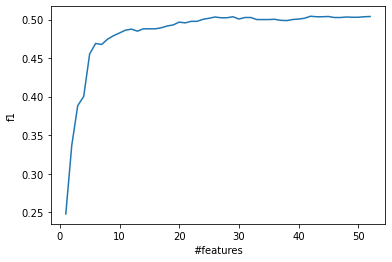

In [16]:
plt.plot(range(1, valid_X.shape[1]), f1v)
plt.xlabel('#features')
plt.ylabel('f1');

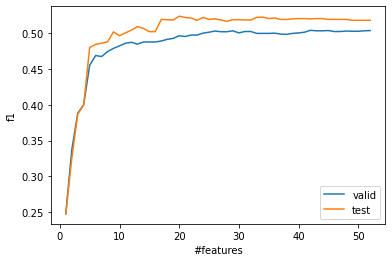

In [17]:
plt.plot(range(1, valid_X.shape[1]), f1v, label='valid')
plt.plot(range(1, test_X.shape[1]), f1t, label='test')
plt.xlabel('#features')
plt.ylabel('f1')
plt.legend();